## Notmnist analysis

Not_mnist is image recognition dataset with the letters from A through J, similar to the well-known mnist dataset.

The objective is to recognize the letters in the images. (A image contains just one letter)

The datasets used on this project are available on http://yaroslavvb.com/upload/notMNIST/

The datasets should be downloaded and decompressed in the input folder (The folder can be changed by modifying the INPUT_FOLDER in preprocess.py)

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from collections import defaultdict
import random
import math

import preprocess


np.random.seed(0)

%matplotlib inline

In [17]:
x, y = preprocess.preprocess("notMNIST_small")

LIMIT = 5000
x = np.array(x)
y = np.array(y)

if LIMIT:
    idx = list(range(len(x)))
    random.shuffle(idx)
    idx = idx[:LIMIT]

    x = x[idx]
    y = y[idx]
    
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

/home/runix/Projects/academic/master_dc_urjc/MISC/notmnist_python/preprocess.py:35: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if dataset == None:


In [18]:
image_by_class = defaultdict(list)
for label, image in zip(y, x):
    image_by_class[label].append(image)
    
for label in image_by_class:
    image_by_class[label] = np.array(image_by_class[label])

# Exploratory analysis

In [4]:
len(x)

5000

In [5]:
for label in image_by_class:
    print("The label {0} has {1} images".format(label, len(image_by_class[label])))

The label B has 526 images
The label F has 502 images
The label C has 490 images
The label I has 485 images
The label G has 529 images
The label A has 509 images
The label H has 488 images
The label D has 502 images
The label E has 498 images
The label J has 471 images


In [14]:
def observation2img(observation, width=28, height=28):
    return np.reshape(observation, newshape=(width, height))

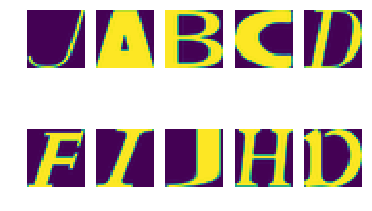

In [19]:
num_samples = 10
for i, img in enumerate(random.sample(list(x), num_samples)):
    plt.subplot(2, num_samples // 2, i + 1)
    plt.axis('off')
    plt.imshow(observation2img(img))

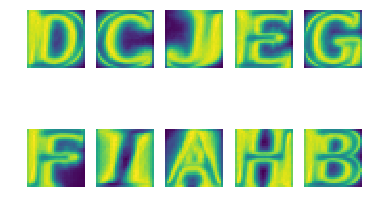

In [20]:
classes_mean = []
tags = []
num_classes = len(image_by_class)
image_means = {}

for i, label in enumerate(image_by_class):
    newimg = np.var(image_by_class[label], axis=(0))
    image_means[label] = newimg
    
    plt.subplot(2, num_classes // 2, i + 1)
    plt.axis('off')
    plt.imshow(observation2img(newimg))

['D', 'C', 'J', 'E', 'G', 'F', 'I', 'A', 'B', 'H']


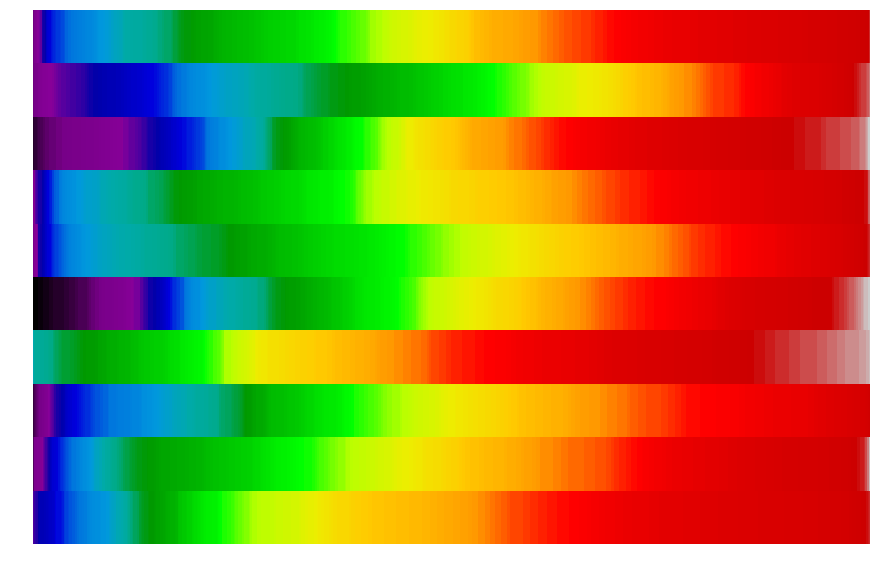

In [21]:
replication_factor = 50
image_letter_means = []
labels = []

for label, image in image_means.items():
    image_letter_means.extend([sorted(image)] * replication_factor)
    labels.append(label)
                               
image_letter_means = np.array(image_letter_means)
                               
fig = plt.figure(figsize = (15, 15))
plt.axis('off')
ax = fig.add_subplot(111)

imgplot = ax.imshow(image_letter_means)
imgplot.set_cmap('nipy_spectral')

print(labels)

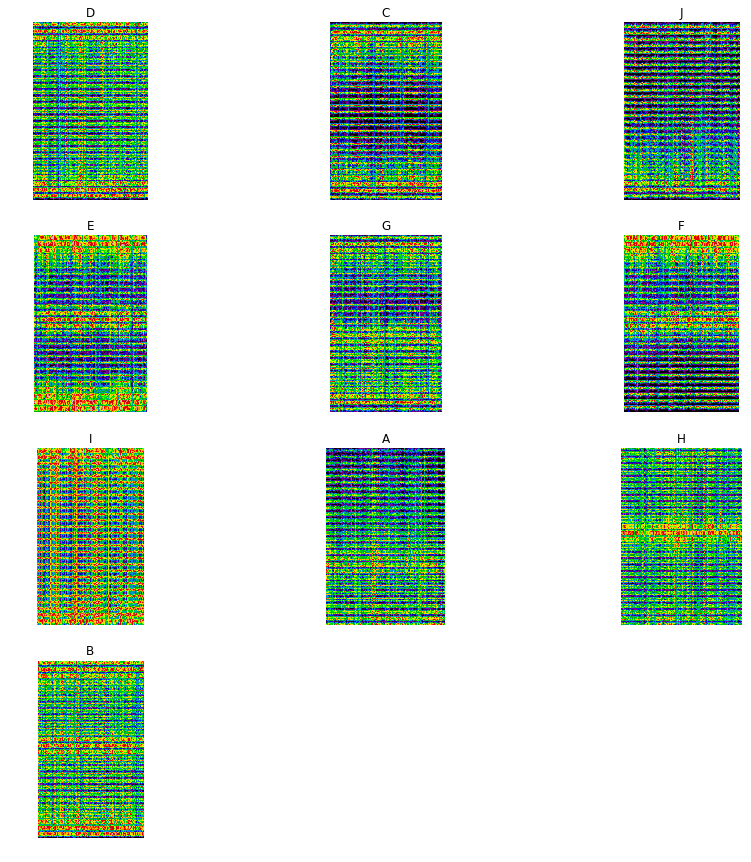

In [22]:
fig = plt.figure(figsize = (15, 15))

for i, label in enumerate(image_by_class):
    img = image_by_class[label]
    
    ax = fig.add_subplot(4, math.ceil(num_classes / 4), i + 1)
    ax.axis('off')
    ax.set_title(label)
    ax.imshow(img.T, cmap="nipy_spectral", interpolation="kaiser")

# Models

In [23]:
from sklearn.model_selection import GridSearchCV
import math

def run_model(estimator, param_grid, print_best_n=6):
    
    clf = GridSearchCV(estimator, param_grid, n_jobs=-1)
    clf.fit(x_train, y_train)

    # Code taken from http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    
    results = sorted(list(zip(means, stds, clf.cv_results_['params'])), 
                     key=lambda x: x[0], reverse=True)[:print_best_n]
    
    for mean, std, params in results:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    
    print()
    print("Detailed classification report:")
    print()

    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()
    
    return clf, (y_true, y_pred)

def display_misclassified_samples(x, y_true, y_pred, num_samples, width=3, class_sept=" - "):
    misclassified_index = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
    
    if num_samples:
        random.shuffle(misclassified_index)
        misclassified_index = misclassified_index[:num_samples]
    
    height = math.ceil(len(misclassified_index) / width)
    
    fig = plt.figure(figsize = (10, 10))
    plt.title("True label "+class_sept+"Pred. label")
    plt.axis("off")
    
    for i, img_id in enumerate(misclassified_index):
        ax = fig.add_subplot(width, height, i + 1)
        ax.axis("off")
        ax.set_title(y_true[img_id]+class_sept+y_pred[img_id])
        ax.imshow(observation2img(x[img_id]))

## SVM

Best parameters set found on development set:

{'gamma': 0.01, 'kernel': 'rbf', 'C': 1}

Grid scores on development set:

0.885 (+/-0.025) for {'gamma': 0.01, 'kernel': 'rbf', 'C': 1}
0.870 (+/-0.018) for {'gamma': 0.001, 'kernel': 'rbf', 'C': 1}
0.858 (+/-0.020) for {'gamma': 0.001, 'kernel': 'sigmoid', 'C': 1}
0.856 (+/-0.013) for {'gamma': 0.01, 'kernel': 'rbf', 'C': 0.1}
0.821 (+/-0.031) for {'gamma': 0.01, 'kernel': 'sigmoid', 'C': 0.1}
0.813 (+/-0.043) for {'gamma': 0.0001, 'kernel': 'rbf', 'C': 1}

Detailed classification report:

             precision    recall  f1-score   support

          A       0.87      0.95      0.91       153
          B       0.94      0.90      0.92       144
          C       0.97      0.87      0.92       140
          D       0.88      0.88      0.88       153
          E       0.94      0.93      0.93       143
          F       0.92      0.92      0.92       158
          G       0.86      0.88      0.87       154
          H       0.91      0.9

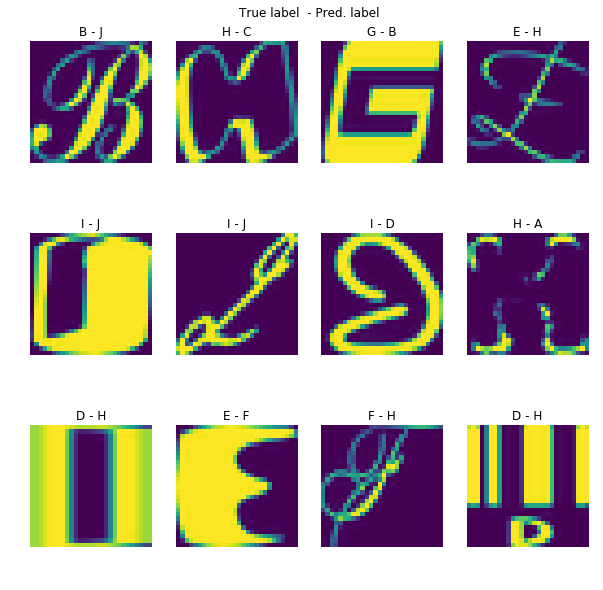

In [25]:
from sklearn import svm

clf, (y_true, y_pred) = run_model(svm.SVC(random_state=0), 
    {
        'C': [0.0001, 0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'sigmoid'],
        'gamma': [0.0001, 0.001, 0.01, 0.1]
    })

display_misclassified_samples(x_test, y_true, y_pred, 12)

## Logistic regression

Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.866 (+/-0.014) for {'C': 0.1}
0.866 (+/-0.001) for {'C': 0.01}
0.849 (+/-0.007) for {'C': 1}
0.845 (+/-0.014) for {'C': 0.001}
0.797 (+/-0.028) for {'C': 0.0001}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          A       0.89      0.94      0.92       132
          B       0.93      0.83      0.87       164
          C       0.86      0.87      0.86       149
          D       0.90      0.90      0.90       165
          E       0.85      0.85      0.85       154
          F       0.89      0.92      0.90       154
          G       0.89      0.87      0.88       163
          H       0.91      0.85      0.87       136
          I       0.84      0.85      0.84       145
          J       0.83      0.91      0.87       138

avg / total       0.88

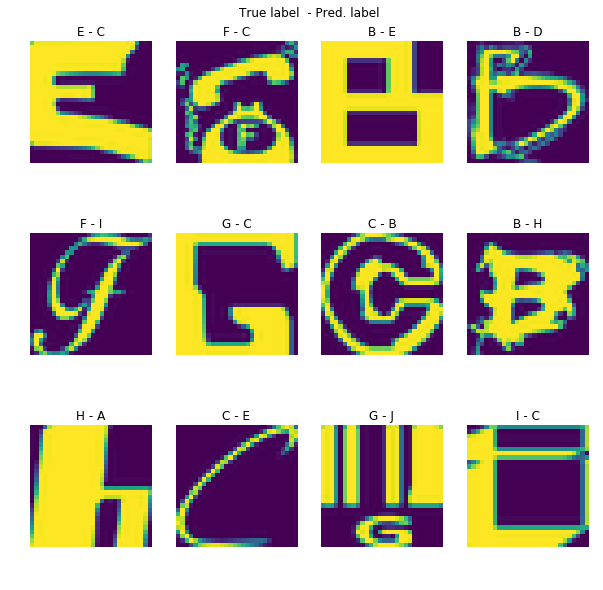

In [15]:
from sklearn import linear_model

clf, (y_true, y_pred) = run_model(linear_model.LogisticRegression(random_state=0), 
    {
        'C': [0.0001, 0.001, 0.01, 0.1, 1],
    })

display_misclassified_samples(x_test, y_true, y_pred, 12)

## Decision trees

Best parameters set found on development set:

{'max_depth': 10, 'criterion': 'entropy', 'min_samples_split': 2}

Grid scores on development set:

0.768 (+/-0.012) for {'max_depth': 10, 'criterion': 'entropy', 'min_samples_split': 2}
0.766 (+/-0.011) for {'max_depth': 10, 'criterion': 'entropy', 'min_samples_split': 4}
0.766 (+/-0.009) for {'max_depth': None, 'criterion': 'entropy', 'min_samples_split': 4}
0.766 (+/-0.009) for {'max_depth': 14, 'criterion': 'entropy', 'min_samples_split': 4}
0.762 (+/-0.017) for {'max_depth': None, 'criterion': 'entropy', 'min_samples_split': 12}
0.762 (+/-0.017) for {'max_depth': 10, 'criterion': 'entropy', 'min_samples_split': 12}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          A       0.78      0.83      0.80       132
          B       0.80      0.69      0.74       164
          C       0.76      

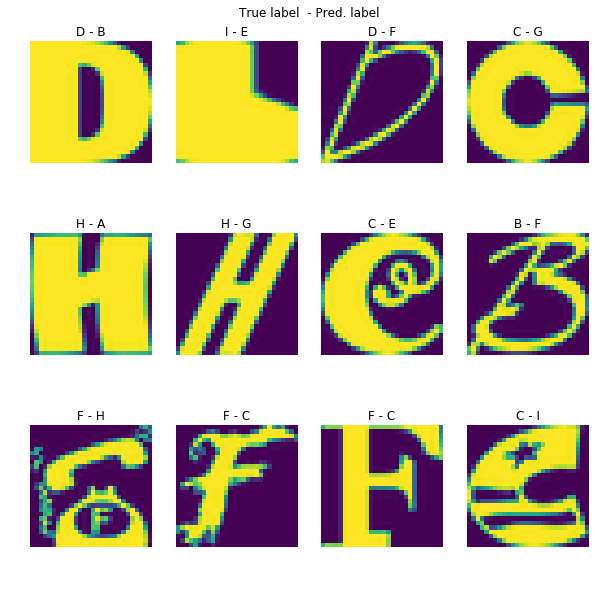

In [17]:
from sklearn import tree


clf, (y_true, y_pred) = run_model(tree.DecisionTreeClassifier(random_state=0), 
    {
        'criterion': ['gini', 'entropy'],
        'min_samples_split': [2, 4, 7, 12],
        'max_depth': [None, 2, 6, 10, 14]
    })

display_misclassified_samples(x_test, y_true, y_pred, 12)

## Random forest

Best parameters set found on development set:

{'max_depth': 10, 'criterion': 'entropy', 'min_samples_split': 4, 'n_estimators': 20}

Grid scores on development set:

0.872 (+/-0.018) for {'max_depth': 10, 'criterion': 'entropy', 'min_samples_split': 4, 'n_estimators': 20}
0.872 (+/-0.013) for {'max_depth': None, 'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 20}
0.871 (+/-0.013) for {'max_depth': 10, 'criterion': 'entropy', 'min_samples_split': 4, 'n_estimators': 15}
0.870 (+/-0.020) for {'max_depth': None, 'criterion': 'gini', 'min_samples_split': 4, 'n_estimators': 20}
0.870 (+/-0.012) for {'max_depth': None, 'criterion': 'entropy', 'min_samples_split': 4, 'n_estimators': 20}
0.867 (+/-0.021) for {'max_depth': 10, 'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 20}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support



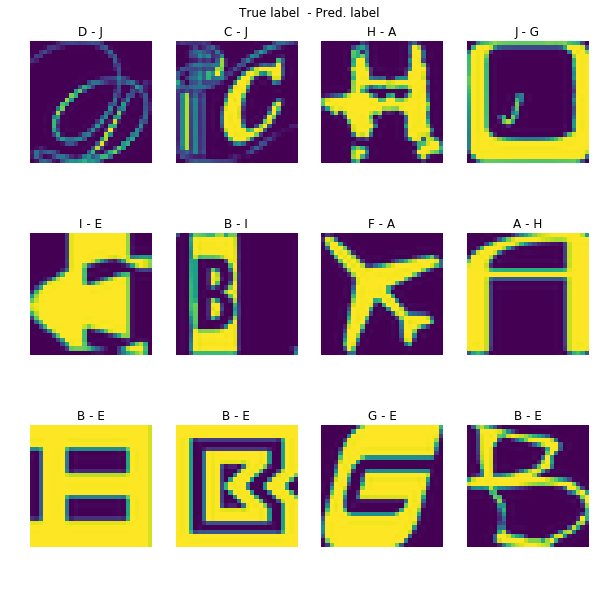

In [19]:
from sklearn.ensemble import RandomForestClassifier

clf, (y_true, y_pred) = run_model(RandomForestClassifier(random_state=0), 
    {
        'criterion': ['gini', 'entropy'],
        'n_estimators': [5, 10, 15, 20],
        'min_samples_split': [2, 4],
        'max_depth': [None, 2, 6, 10]
    })

display_misclassified_samples(x_test, y_true, y_pred, 12)

## Neural networks

In [38]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

In [70]:
x, y = preprocess.preprocess("notMNIST_large")

x = np.array(x)
y = np.array(y)

labels = set(y)

batch_size = 128
nb_classes = len(labels)
nb_epoch = 10


key_map = {letter: i  for i, letter in enumerate(labels)}
key_map_inv = {i: letter for letter, i in key_map.items()}

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

y_dt_train = list(map(lambda x: key_map[x], y_train))
y_dt_test = list(map(lambda x: key_map[x], y_test))

y_oh_train = np_utils.to_categorical(y_dt_train, nb_classes)
y_oh_test = np_utils.to_categorical(y_dt_test, nb_classes)

/home/runix/Projects/academic/master_dc_urjc/MISC/notmnist_python/preprocess.py:35: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if dataset == None:


In [40]:
def print_stats(y_true, y_pred):
    print(classification_report(y_true, y_pred))

## Simple neural networks

In [33]:
model = Sequential()
model.add(Dense(128, input_shape=(x.shape[1],), name="hidden_1"))
model.add(Activation('relu', name="ReLU_1"))
model.add(Dropout(0.3))

model.add(Dense(64, input_shape=(128,), name="hidden_2"))
model.add(Activation('relu', name="ReLU_2"))
model.add(Dropout(0.3))

model.add(Dense(10, name="output"))
model.add(Activation('softmax', name="softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

model.summary()

/home/runix/Projects/academic/master_dc_urjc/MISC/notmnist_python/preprocess.py:35: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if dataset == None:


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 128)               100480    
_________________________________________________________________
ReLU_1 (Activation)          (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_2 (Dense)             (None, 64)                8256      
_________________________________________________________________
ReLU_2 (Activation)          (None, 64)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
output (Dense)               (None, 10)                650       
__________

In [34]:
history = model.fit(x_train, y_oh_train,batch_size=batch_size, epochs=nb_epoch, verbose=1)

Epoch 1/10
13106/13106 [==============================] - 0s - loss: 0.7483 - acc: 0.7739     
Epoch 2/10
13106/13106 [==============================] - 0s - loss: 0.4565 - acc: 0.8706     
Epoch 3/10
13106/13106 [==============================] - 0s - loss: 0.3981 - acc: 0.8839     
Epoch 4/10
13106/13106 [==============================] - 0s - loss: 0.3662 - acc: 0.8933     
Epoch 5/10
13106/13106 [==============================] - 0s - loss: 0.3382 - acc: 0.8987     
Epoch 6/10
13106/13106 [==============================] - 0s - loss: 0.3224 - acc: 0.9037     
Epoch 7/10
13106/13106 [==============================] - 0s - loss: 0.2990 - acc: 0.9088     
Epoch 8/10
13106/13106 [==============================] - 0s - loss: 0.2819 - acc: 0.9152     
Epoch 9/10
13106/13106 [==============================] - 0s - loss: 0.2730 - acc: 0.9177     
Epoch 10/10
13106/13106 [==============================] - 0s - loss: 0.2548 - acc: 0.9217     


             precision    recall  f1-score   support

          A       0.92      0.93      0.92       547
          B       0.89      0.90      0.90       586
          C       0.95      0.91      0.93       594
          D       0.89      0.94      0.91       558
          E       0.92      0.89      0.91       566
          F       0.93      0.93      0.93       568
          G       0.90      0.91      0.91       551
          H       0.92      0.91      0.91       561
          I       0.92      0.86      0.89       548
          J       0.88      0.93      0.90       539

avg / total       0.91      0.91      0.91      5618



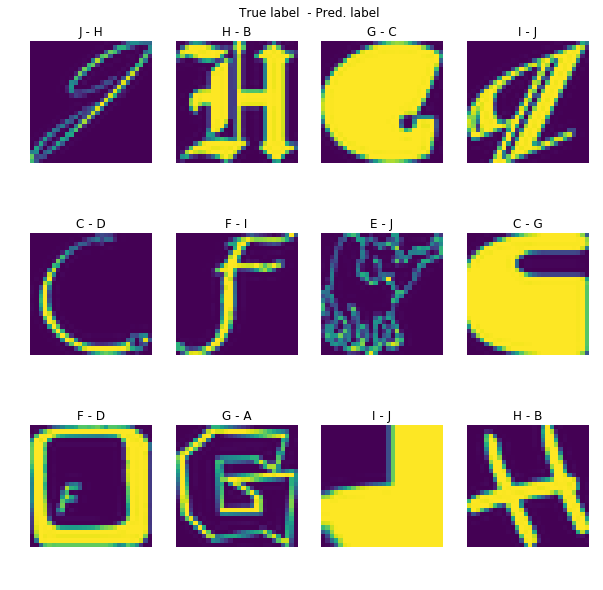

In [35]:
y_oh_hat = model.predict(x_test)

y_hat = list(map(lambda x: key_map_inv[x], y_oh_hat.argmax(1)))

print_stats(y_test, y_hat)
display_misclassified_samples(x_test, y_test, y_hat, 12)

## Convulutive neural networks

In [77]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import keras

# Passes through the dataset
nb_epoch = 8

# Samples in a given time
batch_size = 128

x_train = np.reshape(x_train, newshape=(-1, 28, 28, 1))
x_test = np.reshape(x_test, newshape=(-1, 28, 28, 1))

In [78]:
model = Sequential()


# Convolutions
model.add(Conv2D(32, kernel_size=[3, 3], 
                 activation='relu',
                 input_shape=(28, 28, 1)))

model.add(Conv2D(64, kernel_size=[3, 3],
                 activation='relu'))

# Down-sample
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Fully connected network
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 24, 24, 64)        9280      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
__________

Train on 13106 samples, validate on 5618 samples
Epoch 1/8
13106/13106 [==============================] - 25s - loss: 1.0309 - acc: 0.6744 - val_loss: 0.6381 - val_acc: 0.8104
Epoch 2/8
13106/13106 [==============================] - 24s - loss: 0.6345 - acc: 0.8099 - val_loss: 0.4957 - val_acc: 0.8622
Epoch 3/8
13106/13106 [==============================] - 24s - loss: 0.5646 - acc: 0.8348 - val_loss: 0.4701 - val_acc: 0.8610
Epoch 4/8
13106/13106 [==============================] - 24s - loss: 0.5151 - acc: 0.8434 - val_loss: 0.4081 - val_acc: 0.8802
Epoch 5/8
13106/13106 [==============================] - 24s - loss: 0.4695 - acc: 0.8590 - val_loss: 0.4253 - val_acc: 0.8763
Epoch 6/8
13106/13106 [==============================] - 24s - loss: 0.4568 - acc: 0.8615 - val_loss: 0.4125 - val_acc: 0.8782
Epoch 7/8
13106/13106 [==============================] - 25s - loss: 0.4312 - acc: 0.8691 - val_loss: 0.4167 - val_acc: 0.8791
Epoch 8/8
13106/13106 [==============================] - 25s -

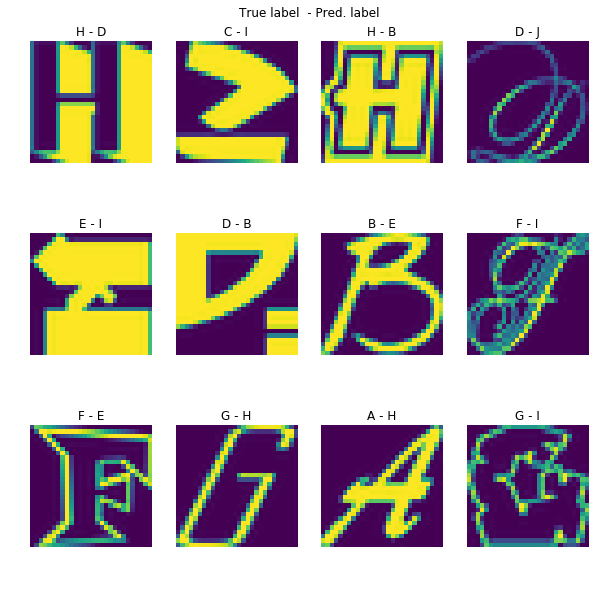

In [79]:
model.fit(x_train, y_oh_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          verbose=1,
          validation_data=(x_test, y_oh_test))


y_oh_hat = model.predict(x_test)
y_hat = list(map(lambda x: key_map_inv[x], y_oh_hat.argmax(1)))

print_stats(y_test, y_hat)
display_misclassified_samples(x_test, y_test, y_hat, 12)